This notebook explores the Airbnb dataset. The datasets of interest are the user training data, user test data, and session data. Lets first take a look at the user training and test data.

In [1]:
#Show plots in the notebook
%matplotlib inline

from sklearn import datasets, preprocessing, cross_validation, feature_extraction
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
try:
    import urllib.request as urllib2
except ImportError:
    import urllib2
import random


In [2]:
train_users ='train_users_2.csv'
test_users = 'test_users.csv'
df_train = pd.read_csv(train_users)
df_test = pd.read_csv(test_users)

print("Shape of user training data: ", df_train.shape)
print("Shape of user test data: ", df_test.shape)


Shape of user training data:  (213451, 16)
Shape of user test data:  (62096, 15)


In [3]:
# Exploratory data analysys on the data
# Combine the test and train data first
all_users = pd.concat((df_train, df_test), axis=0, ignore_index=True)
# Look at some of the instances
all_users.head(n=5)


,affiliate_channel,affiliate_provider,age,country_destination,date_account_created,date_first_booking,first_affiliate_tracked,first_browser,first_device_type,gender,id,language,signup_app,signup_flow,signup_method,timestamp_first_active
0,direct,direct,NaN,NDF,2010-06-28,NaN,untracked,Chrome,Mac Desktop,-unknown-,gxn3p5htnn,en,Web,0,facebook,20090319043255
1,seo,google,38,NDF,2011-05-25,NaN,untracked,Chrome,Mac Desktop,MALE,820tgsjxq7,en,Web,0,facebook,20090523174809
2,direct,direct,56,US,2010-09-28,2010-08-02,untracked,IE,Windows Desktop,FEMALE,4ft3gnwmtx,en,Web,3,basic,20090609231247
3,direct,direct,42,other,2011-12-05,2012-09-08,untracked,Firefox,Mac Desktop,FEMALE,bjjt8pjhuk,en,Web,0,facebook,20091031060129
4,direct,direct,41,US,2010-09-14,2010-02-18,untracked,Chrome,Mac Desktop,-unknown-,87mebub9p4,en,Web,0,basic,20091208061105


There are 213451 training instances, with 15 attributes, and 1 label, 'country_destination'. <br />
There are 62096 instances of test data for which we need to predict the country_destination

Most of the attributes are categorical, and need to be encoded. Some of the data like age is numerical, and have NaN values. Also, having taken a look at the data offline, some of the attributes like first_browser and gender have values -unknown- in some of the rows. Let's first take a look at the label, country_destination

In [4]:
print (pd.value_counts(df_train['country_destination'].values))

NDF      124543
US        62376
other     10094
FR         5023
IT         2835
GB         2324
ES         2249
CA         1428
DE         1061
NL          762
AU          539
PT          217
dtype: int64


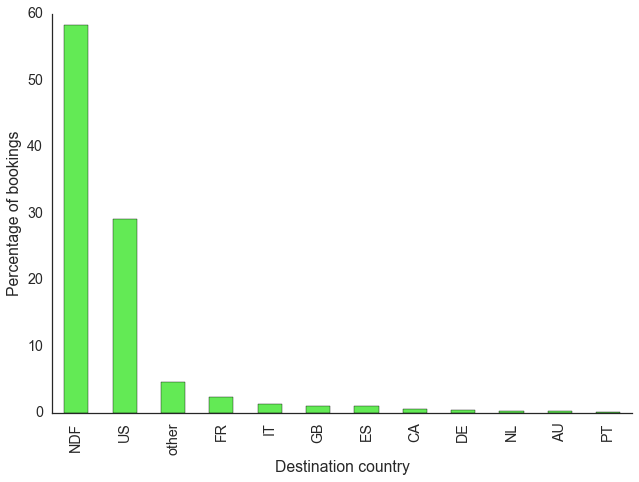

In [5]:
# Using seaborn to get prettier charts
# See http://stanford.edu/~mwaskom/software/seaborn/
import seaborn as sbrn
sbrn.set_style("white")
sbrn.set_context("talk", font_scale=1.1)

#print(nan_rows)
des_countries = df_train.country_destination.value_counts(dropna=False) / df_train.shape[0] * 100
des_countries.plot(kind='bar',color='#63EA55')
plt.xlabel('Destination country')
plt.ylabel("Percentage of bookings")
sbrn.despine()

The most common value is 'NDF', which means that the user did not book a destination. US comes in second, followed by other.

In [6]:
all_users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 275547 entries, 0 to 275546
Data columns (total 16 columns):
affiliate_channel          275547 non-null object
affiliate_provider         275547 non-null object
age                        158681 non-null float64
country_destination        213451 non-null object
date_account_created       275547 non-null object
date_first_booking         88908 non-null object
first_affiliate_tracked    269462 non-null object
first_browser              275547 non-null object
first_device_type          275547 non-null object
gender                     275547 non-null object
id                         275547 non-null object
language                   275547 non-null object
signup_app                 275547 non-null object
signup_flow                275547 non-null int64
signup_method              275547 non-null object
timestamp_first_active     275547 non-null int64
dtypes: float64(1), int64(2), object(13)
memory usage: 35.7+ MB


As seen, there are a lot of missing values for age and date_first_booking. For test users, the date_first_booking is not present for any of the users since they are yet to make the first booking. This can be seen from the test data: 

In [7]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62096 entries, 0 to 62095
Data columns (total 15 columns):
id                         62096 non-null object
date_account_created       62096 non-null object
timestamp_first_active     62096 non-null int64
date_first_booking         0 non-null float64
gender                     62096 non-null object
age                        33220 non-null float64
signup_method              62096 non-null object
signup_flow                62096 non-null int64
language                   62096 non-null object
affiliate_channel          62096 non-null object
affiliate_provider         62096 non-null object
first_affiliate_tracked    62076 non-null object
signup_app                 62096 non-null object
first_device_type          62096 non-null object
first_browser              62096 non-null object
dtypes: float64(2), int64(2), object(11)
memory usage: 7.6+ MB


Since there are no values for this column in the test data, it can be safely dropped in the modelling stage. It's still interesting to take a look at the first booking trend, which shows an increased number of bookings during the middle of the year

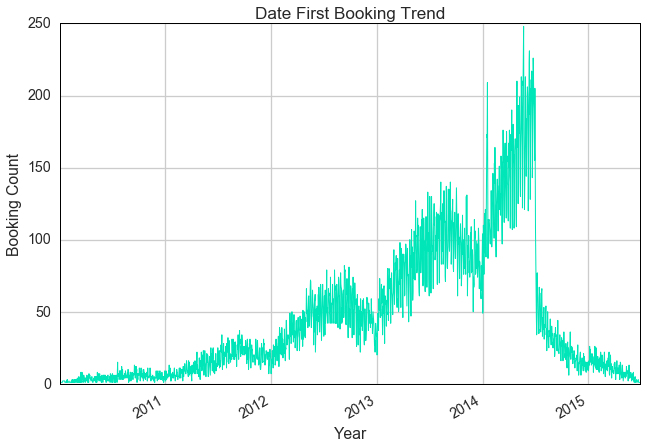

In [11]:
sbrn.set_context("talk", font_scale=1.1)
sbrn.set_style("whitegrid", {'axes.edgecolor': '0'})
df_train['date_first_booking'] = pd.to_datetime(df_train['date_first_booking'])
plt.title("Date First Booking Trend")
plt.ylabel("Booking Count")
plt.xlabel("Year")
df_train['date_first_booking'].value_counts().plot(kind='line', color = '#00e6b8', linewidth=1.0)

The age attribute: 

In [11]:
print (all_users['age'].describe())

count    158681.000000
mean         47.145310
std         142.629468
min           1.000000
25%          28.000000
50%          33.000000
75%          42.000000
max        2014.000000
Name: age, dtype: float64


The age data seems to be a little messed up. The max value of the age is 2014, which maybe the year information provided by  users. This data needs to be cleaned up. The distribution of age can be observed from the following plots:

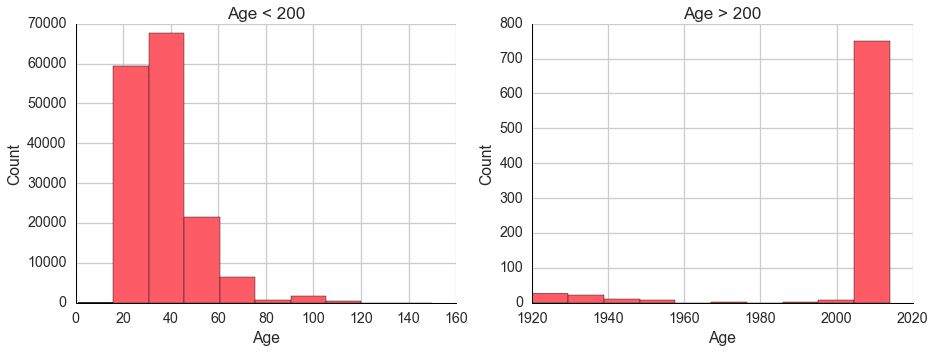

In [12]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(15, 5))
axes[0].set_title("Age < 200")
axes[0].set_xlabel("Age")
axes[0].set_ylabel("Count")
all_users[all_users.age < 200].age.hist(bins=10, color='#FD5C66', ax=axes[0])
axes[1].set_title("Age > 200")
axes[1].set_xlabel("Age")
axes[1].set_ylabel("Count")

all_users[all_users.age > 200].age.hist(bins=10, color='#FD5C66',  ax=axes[1])
sbrn.despine()

From the plots, we can assume that some people have entered the year instead of age. Also, some values are below 18, and above 90. One way of handling this is to set the age for values greater than 95 and less than 16 to NaN. 

Looking at the gender information, we see that for nearly half of the data, gender is marked as unknown:

In [29]:
print(all_users.gender.value_counts(dropna=False))

-unknown-    129480
FEMALE        77524
MALE          68209
OTHER           334
Name: gender, dtype: int64


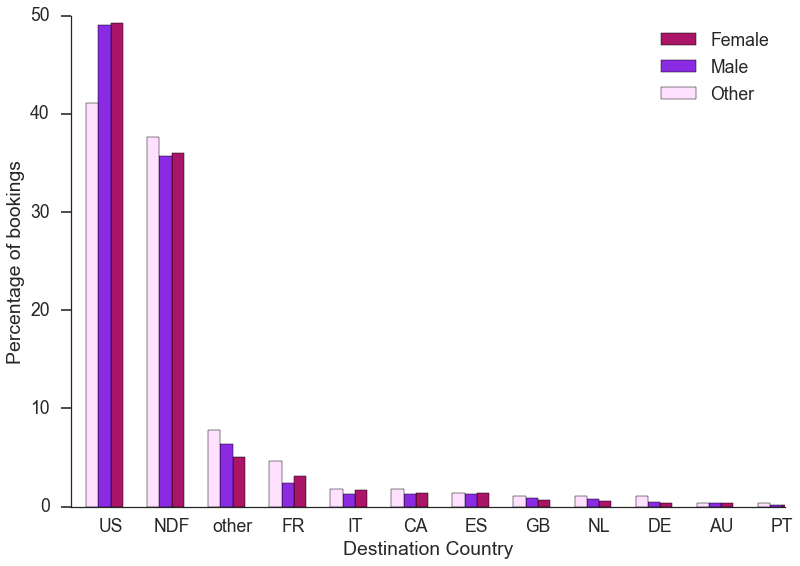

In [130]:

sbrn.set_context("poster", font_scale=1.1)
women = sum(df_train['gender'] == 'FEMALE')
men = sum(df_train['gender'] == 'MALE')
other = sum(df_train['gender'] == 'OTHER')

female_destinations = df_train.loc[df_train['gender'] == 'FEMALE', 'country_destination'].value_counts() / women * 100
male_destinations = df_train.loc[df_train['gender'] == 'MALE', 'country_destination'].value_counts() / men * 100
other_destinations = df_train.loc[df_train['gender'] == 'OTHER', 'country_destination'].value_counts() / other * 100

female_destinations.plot(kind='bar', width=0.2, color='#AB1567', position=0, label='Female', rot=0)
male_destinations.plot(kind='bar', width=0.2, color='#8A2BE2', position=1, label='Male', rot=0)
other_destinations.plot(kind='bar', width=0.2, color='#FFE1FF', position=2, label='Other', rot=0)

plt.legend()
plt.xlabel('Destination Country')
plt.ylabel('Percentage of bookings')

sbrn.despine()
plt.show()


The distribution of destination of booking is the similar for male and female users. Users with gender other have slightly lower bookings within the US and higher percentage bookings in other locations

<b> Account Created, Timestamp first Active </b>

Account creation date trends maybe indicative of the time of the year the user wanted to book a holiday, and hence the location of booking. PLotting the trend for both these attributes

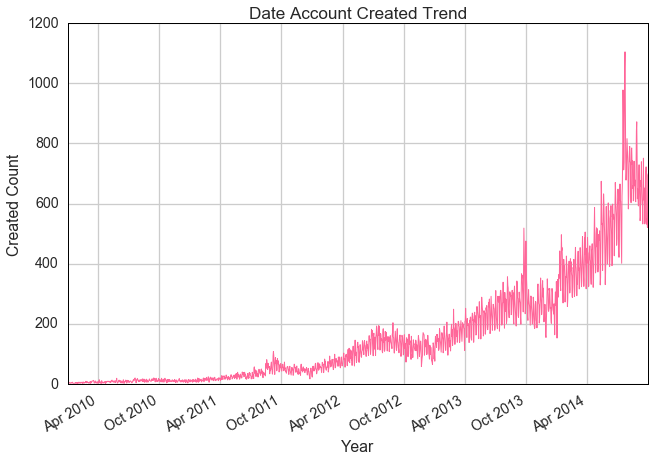

In [13]:
sbrn.set_context("talk", font_scale=1.1)
sbrn.set_style("whitegrid", {'axes.edgecolor': '0'})
all_users['date_account_created'] = pd.to_datetime(all_users['date_account_created'])
all_users['date_account_created'].value_counts().plot(kind='line', color = '#ff6699', linewidth=1.0)
plt.title("Date Account Created Trend")
plt.ylabel("Created Count")
plt.xlabel("Year")

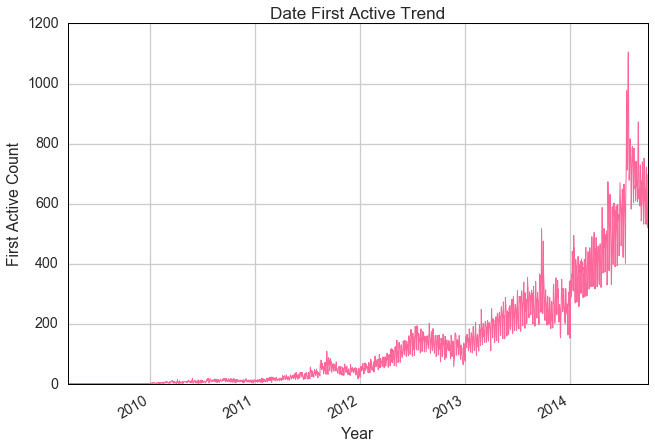

In [14]:
all_users['date_first_active'] = pd.to_datetime((all_users.timestamp_first_active // 1000000), format='%Y%m%d')
all_users['date_first_active'].value_counts().plot(kind='line', color = '#ff6699', linewidth=1.0)
plt.title("Date First Active Trend")
plt.ylabel("First Active Count")
plt.xlabel("Year")

The trend looks the same for both attributes. The two attributes are very similar - the date when the user first created the account, and the date the user was first active. It would seem that users create Airbnb accounts when they need to look for a place to stay or to rent out their property.

<b> Sign up details </b>

A majority of the signup has been through the Airbnb website:

In [100]:
print (pd.value_counts(all_users['signup_method'].values))

basic       198222
facebook     74864
google        2438
weibo           23
dtype: int64


In [101]:
print (pd.value_counts(all_users['signup_app'].values))

Web        219918
iOS         34593
Android     10519
Moweb       10517
dtype: int64


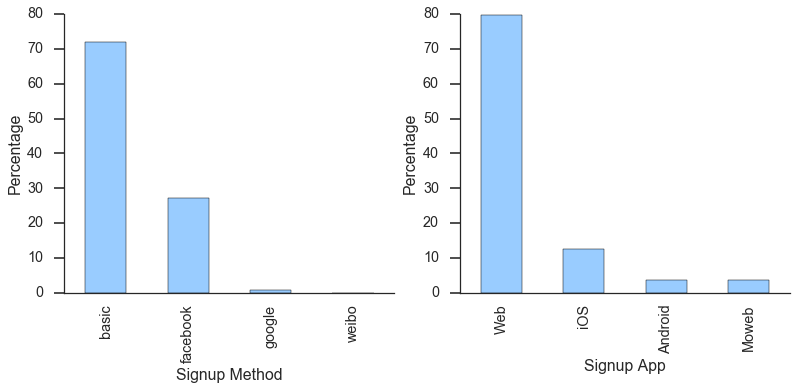

In [98]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(13, 5))
sbrn.set_style("white", {'ytick.major.size': 10.0})
sbrn.set_context("poster", font_scale=0.9)

signup_method = all_users.signup_method.value_counts(dropna=False) / all_users.shape[0] * 100
signup_method.plot(kind='bar',color='#99ccff', ax=axes[0])
axes[0].set_xlabel('Signup Method')
axes[0].set_ylabel("Percentage")
sbrn.despine()

signup_app = all_users.signup_app.value_counts(dropna=False) / all_users.shape[0] * 100
signup_app.plot(kind='bar',color='#99ccff', ax=axes[1])
axes[1].set_xlabel('Signup App')
axes[1].set_ylabel("Percentage")

sbrn.despine()

<b>First Device and Browser </b>

The majority of the users used Mac Desktop as the first Device. Since the majority of the bookings are from the US, this is exptected. For the first browser, Chrome, safari, and Firefox were primarily used

In [117]:
print (pd.value_counts(all_users['first_device_type'].values))

Mac Desktop           106328
Windows Desktop        86948
iPhone                 39814
iPad                   18036
Other/Unknown          11167
Android Phone           9458
Android Tablet          2098
Desktop (Other)         1507
SmartPhone (Other)       191
dtype: int64


In [118]:
print (pd.value_counts(all_users['first_browser'].values))

Chrome                  78671
Safari                  53302
-unknown-               44394
Firefox                 38665
Mobile Safari           29636
IE                      24744
Chrome Mobile            3186
Android Browser          1577
AOL Explorer              254
Opera                     228
Silk                      172
IE Mobile                 118
BlackBerry Browser         89
Chromium                   83
Mobile Firefox             64
Maxthon                    60
Apple Mail                 45
Sogou Explorer             43
SiteKiosk                  27
RockMelt                   24
Iron                       24
IceWeasel                  14
Yandex.Browser             14
Pale Moon                  13
SeaMonkey                  12
CometBird                  12
Camino                      9
Opera Mini                  8
TenFourFox                  8
wOSBrowser                  7
CoolNovo                    6
Opera Mobile                4
Avant Browser               4
Mozilla   

The two attributes are highly correlated. For example, Safari browser is used primarily on Macs, and IE on Windows. 

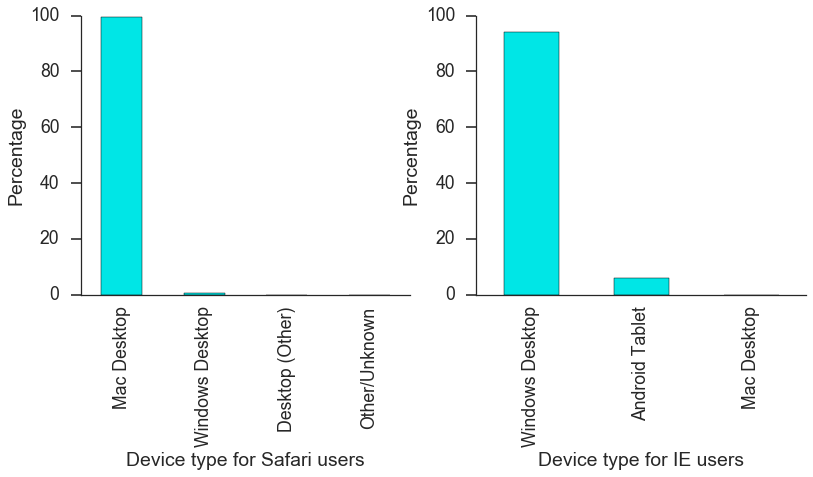

In [147]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(13, 5))

safari_users = all_users[all_users.first_browser == 'Safari']

perc1 = safari_users.first_device_type.value_counts() / safari_users.shape[0] * 100
axes[0].set_xlabel("Device type for Safari users")
axes[0].set_ylabel("Percentage")
perc1.plot(kind='bar',color='#00e6e6', ax=axes[0])

ie_users = all_users[all_users.first_browser == 'IE']
perc2 = ie_users.first_device_type.value_counts() / ie_users.shape[0] * 100
axes[1].set_xlabel("Device type for IE users")
axes[1].set_ylabel("Percentage")
perc2.plot(kind='bar',color='#00e6e6', ax=axes[1])

sbrn.despine()

Most of the users are english users as seen in the language distribution. Around 95% of the users are englisg language users.

In [150]:
print (pd.value_counts(all_users['language'].values))

en           265538
zh             2634
fr             1508
es             1174
ko             1116
de              977
it              633
ru              508
ja              345
pt              322
sv              176
nl              134
tr               92
da               75
pl               75
no               51
cs               49
el               30
th               28
hu               25
id               23
fi               20
ca                6
is                5
hr                2
-unknown-         1
dtype: int64


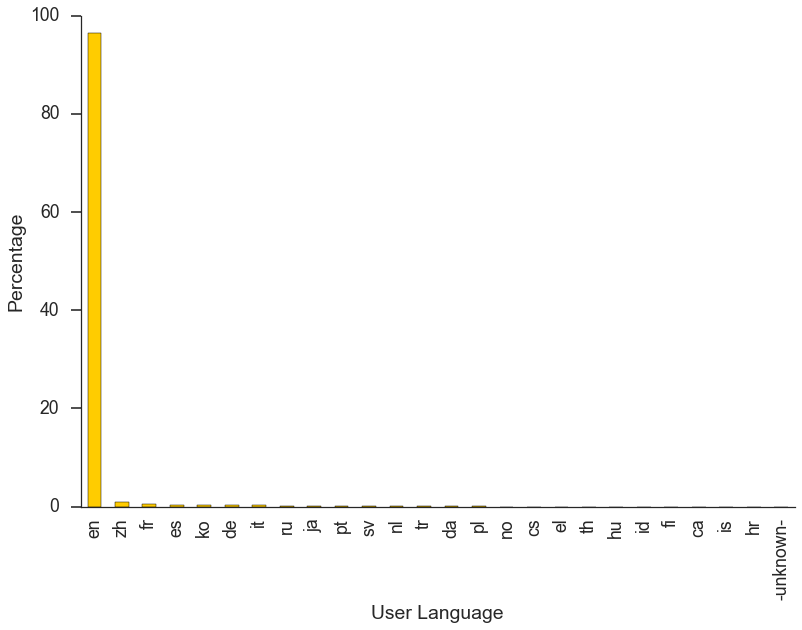

In [154]:
lang = all_users.language.value_counts() / all_users.shape[0] * 100
plt.xlabel("User Language")
plt.ylabel("Percentage")
lang.plot(kind='bar',color='#ffcc00')
sbrn.despine()

The last two attributes of interest are affiliate_channel and affiliate_provider. The values counts for both of the these attributes are as shown:

In [155]:
print (pd.value_counts(all_users['affiliate_channel'].values))

direct           181571
sem-brand         36439
sem-non-brand     20075
seo               14362
other              9547
api                8167
content            4118
remarketing        1268
dtype: int64


In [156]:
print (pd.value_counts(all_users['affiliate_provider'].values))

direct                 181270
google                  65956
other                   13036
facebook                 3996
bing                     3719
craigslist               3475
padmapper                 836
vast                      830
yahoo                     653
facebook-open-graph       566
gsp                       455
meetup                    358
email-marketing           270
naver                      66
baidu                      32
yandex                     18
wayn                        8
daum                        3
dtype: int64


### Session data

Along with user training data, session information for users is also provided by Airbnb. Let's look at the session data in some detail

In [157]:
sessions= pd.read_csv('airbnb/sessions.csv')

In [158]:
print(sessions.shape)
print(sessions.info())


(10567737, 6)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 10567737 entries, 0 to 10567736
Data columns (total 6 columns):
user_id          object
action           object
action_type      object
action_detail    object
device_type      object
secs_elapsed     float64
dtypes: float64(1), object(5)
memory usage: 564.4+ MB
None


In [159]:
sessions.head()

,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753
2,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,301
3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141
4,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,435


The session data has 6 attributes as seen. For each user, the actions performed in the session are captured, along with information such as device type and number of seconds elapsed perfroming each action. However, the information is present only for 135484 users, while we have 213451 users in the training data, and 62096 users in the test data. 

In [170]:
print(len(sessions.user_id.unique()))

135484


In [171]:
df_sess = sessions.groupby(["user_id"])["user_id"].count().reset_index(name="session_count")
df_sess.session_count.describe()


count    135483.000000
mean         77.745850
std         112.563746
min           1.000000
25%          16.000000
50%          41.000000
75%          95.000000
max        2722.000000
Name: session_count, dtype: float64

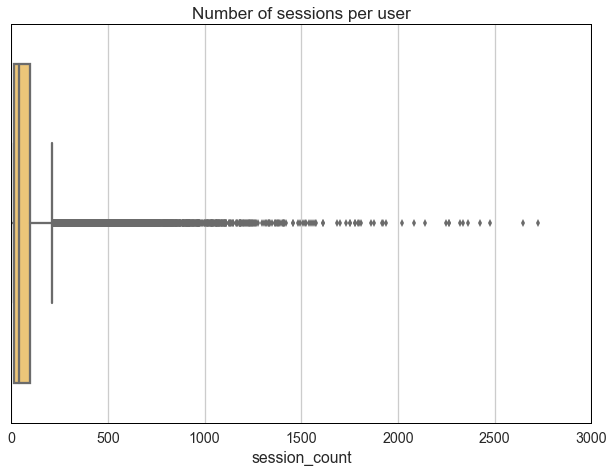

In [186]:
sbrn.set_context("talk", font_scale=1.1)
sbrn.set_style("whitegrid", {'axes.edgecolor': '0'})
plt.title("Number of sessions per user")
ax = sbrn.boxplot(x=df_sess["session_count"], color='#ffcc66')

For each user, there are an average of 77 session instances

The number of seconds spent by each user browsing and booking can be informative, and a possible feature which can be generated to be added to the training set. 

In [187]:
secs = sessions.groupby(['user_id'])['secs_elapsed'].sum().reset_index()
secs.columns = ['user_id','secs_elapsed']
secs.describe()

,secs_elapsed
count,134057.000000
mean,1505579.082249
std,1896684.768312
min,0.000000
25%,273401.000000
50%,867002.000000
75%,2017778.000000
max,38221363.000000


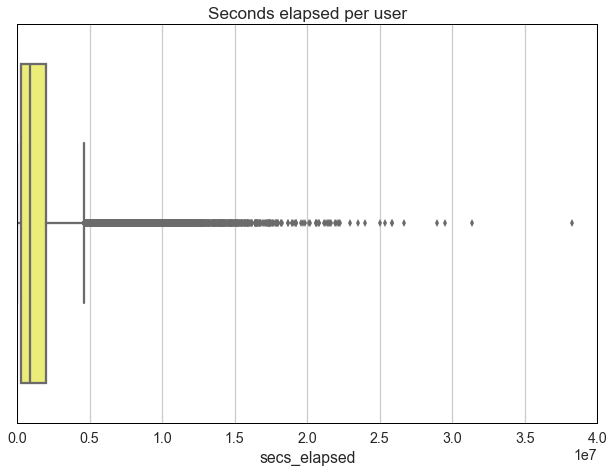

In [188]:
sbrn.set_context("talk", font_scale=1.1)
sbrn.set_style("whitegrid", {'axes.edgecolor': '0'})
plt.title("Seconds elapsed per user")
ax = sbrn.boxplot(x=secs["secs_elapsed"], color='#ffff66')

Device type for session is a filed which is similar to first device type field in the user training data. 

In [190]:
print(sessions.device_type.value_counts())

Mac Desktop                         3594286
Windows Desktop                     2658539
iPhone                              2105031
Android Phone                        839637
iPad Tablet                          683414
Android App Unknown Phone/Tablet     273652
-unknown-                            211279
Tablet                               139886
Linux Desktop                         28373
Chromebook                            22348
iPodtouch                              8198
Windows Phone                          2047
Blackberry                              979
Opera Phone                              68
Name: device_type, dtype: int64


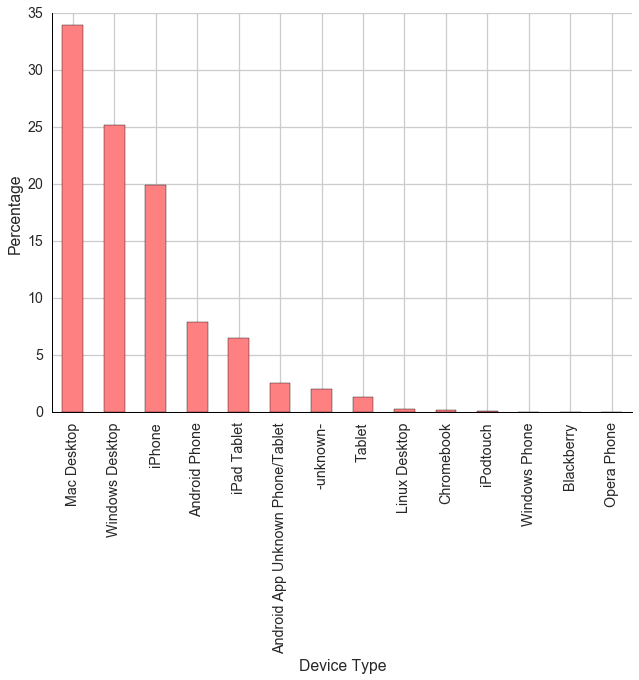

In [194]:
dt = sessions.device_type.value_counts() / sessions.shape[0] * 100
plt.xlabel("Device Type")
plt.ylabel("Percentage")
dt.plot(kind='bar',color='#ff8080')
sbrn.despine()

<b> Actions, action type, and action details </b>

The session data has information regarding each action that a user performs, like click, confirm etc, and which action_type bucket that action falls into. Also, details regarding the action are given

In [198]:
print(sessions.action_type.value_counts())

view                3560902
data                2103770
click               1996183
-unknown-           1031170
submit               623357
message_post          87103
partner_callback      19132
booking_request       18773
modify                 1139
booking_response          4
Name: action_type, dtype: int64


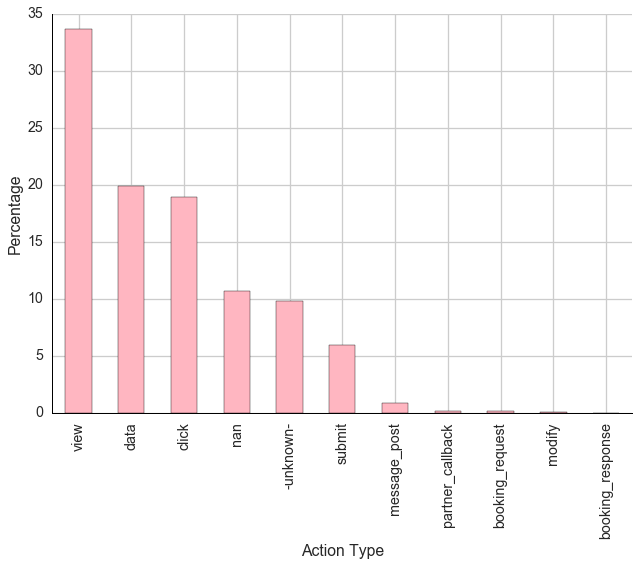

In [199]:
dt = sessions.action_type.value_counts(dropna = False) / sessions.shape[0] * 100
plt.xlabel("Action Type")
plt.ylabel("Percentage")
dt.plot(kind='bar',color='#FFB6C1')
sbrn.despine()

In [200]:
print(sessions.action.value_counts(dropna = False))

show                         2768278
index                         843699
search_results                725226
personalize                   706824
search                        536057
ajax_refresh_subtotal         487744
update                        365130
similar_listings              364624
social_connections            339000
reviews                       320591
active                        188036
similar_listings_v2           168788
lookup                        162041
create                        155887
dashboard                     152952
header_userpic                141830
collections                   124417
edit                          109083
campaigns                     105028
track_page_view                81117
NaN                            79626
unavailabilities               78317
qt2                            64651
notifications                  59392
confirm_email                  58726
requested                      57034
identity                       53631
a

In [201]:
print(sessions.action_detail.value_counts(dropna = False))

view_search_results               1776885
p3                                1376550
NaN                               1126204
-unknown-                         1031141
wishlist_content_update            706824
user_profile                       656839
change_trip_characteristics        487744
similar_listings                   364624
user_social_connections            336799
update_listing                     269779
listing_reviews                    269021
dashboard                          152952
user_wishlists                     152672
header_userpic                     141830
message_thread                     132395
edit_profile                       108686
message_post                        87103
contact_host                        81041
unavailable_dates                   77795
confirm_email_link                  58422
create_user                         54878
change_contact_host_dates           52517
user_profile_content_update         50434
user_reviews                      